In [1]:
#Simulate an MA(2) process and make forecasts

In [2]:
# Import time module
from datetime import datetime as dt

# Record start time
start = dt.now()

from  statsmodels.tsa.arima_process import ArmaProcess
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# generate 1,000 samples

np.random.seed(42)

ma2= np.array([1, 0.9, 0.3])
ar2 = np.array([1, 0, 0])

MA2_process = ArmaProcess(ar2, ma2).generate_sample(nsample=1000)

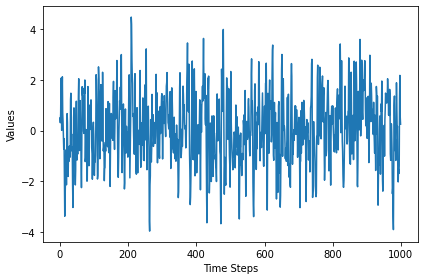

In [4]:
# Plot your simulated moving average

fig, ax = plt.subplots()

ax.plot(MA2_process)
ax.set_xlabel("Time Steps")
ax.set_ylabel("Values")


#fig.autofmt_xdate()
plt.tight_layout()

In [5]:
# Run ADF test, and check if the process is stationary

from statsmodels.tsa.stattools import adfuller

ADF_result = adfuller(MA2_process)

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -14.005444309194493
p-value: 3.795601616713556e-26


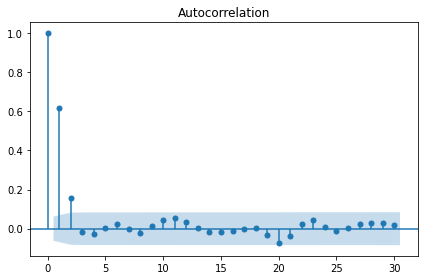

In [6]:
# Plot the ACF, and see if there are significant coefficients after lag 2

from statsmodels.graphics.tsaplots import plot_acf

plot_acf(MA2_process, lags=30)
plt.tight_layout()

In [7]:
# Separate your simulated series into train and test sets. Take the first 800 timesteps
# for the train set, and assign the rest to the test set.

df = pd.DataFrame({'value': MA2_process})

train = df[:800].copy()
test = df[800:].copy()

print(len(train))
print(len(test))

800
200


In [8]:
# Make forecasts over the test set. Use the mean, last value, and an MA(2) model.
# Make sure you repeatedly forecast 2 timesteps at a time using the recursive_forecast function we defined.

from statsmodels.tsa.statespace.sarimax import SARIMAX

def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    total_len = train_len + horizon
    
    if method == 'mean':
        pred_mean = []
    
        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))
            
        return pred_mean
    elif method == 'last':
        pred_last_value = []
        
        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))
            
        return pred_last_value
    elif method == 'MA':
        pred_MA = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(0,0,2))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_MA.extend(oos_pred)
        return pred_MA

In [9]:
# Create an empty dataframe
#pred_df = pd.DataFrame()

TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 2

pred_mean = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_MA2 = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'MA')

test.loc[:, 'pred_mean'] = pred_mean
test.loc[:, 'pred_last_value'] = pred_last_value
test.loc[:, 'pred_MA2'] = pred_MA2

test.head()

,value,pred_mean,pred_last_value,pred_MA2
800,0.973560,-0.017430,0.259693,0.065366
801,0.337338,-0.017430,0.259693,0.017984
802,-0.086834,-0.015752,0.337338,-0.180397
803,-0.530580,-0.015752,0.337338,-0.116820
804,-0.821708,-0.016481,-0.530580,-0.405768


In [10]:
# Measure the MSE, and identify your champion model.
from sklearn.metrics import mean_squared_error

mse_mean = mean_squared_error(test['value'], test['pred_mean'])
mse_last = mean_squared_error(test['value'], test['pred_last_value'])
mse_MA = mean_squared_error(test['value'], test['pred_MA2'])

print(mse_mean, mse_last, mse_MA)

1.8635013982365882 1.988201688527919 1.2323542190601646


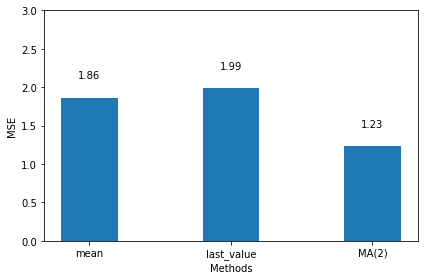

In [11]:
fig, ax = plt.subplots()

x = ['mean', 'last_value', 'MA(2)']
y = [mse_mean, mse_last, mse_MA]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Methods')
ax.set_ylabel('MSE')
ax.set_ylim(0, 3)

for index, value in enumerate(y):
    plt.text(x=index, y=value+0.25, s=str(round(value, 2)), ha='center')

plt.tight_layout()

In [12]:
# Record end time

end = dt.now()
elapsed = end - start

print("The program took: %02d:%02d:%02d:%02d" % (elapsed.days, elapsed.seconds // 3600, elapsed.seconds // 60 % 60, elapsed.seconds % 60))

The program took: 00:00:02:08
